In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [3]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

# Load Tracks

In [4]:
# with open(save_dir + '/lin_alt.pkl', 'rb') as f:
#     lin_tracks_obj = pickle.load(f)
# with open(save_dir + '/thompson_alt.pkl', 'rb') as f:
#     thompson_tracks_obj = pickle.load(f)
with open(save_dir + 'cpol_twpice_test.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [5]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'small_velocity', 
    'small_offset']

In [6]:
excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded.where(excluded==False).dropna()
excluded

scan  time                 uid
31    2006-02-09 05:10:00  0       True
32    2006-02-09 05:20:00  0       True
33    2006-02-09 05:30:00  0       True
34    2006-02-09 05:40:00  0       True
35    2006-02-09 05:50:00  0      False
                                  ...  
675   2006-02-13 17:50:00  49     False
676   2006-02-13 18:00:00  49     False
677   2006-02-13 18:10:00  49     False
678   2006-02-13 18:20:00  49     False
679   2006-02-13 18:30:00  49     False
Length: 512, dtype: bool

In [68]:
included = np.logical_not(excluded)
rear_fed = (tracks_obj.tracks_class['inflow_type'].xs(0, level='level') == 'Rear Fed').values

rear_fed = tracks_obj.tracks_class.xs(0, level='level')['inflow_type'][np.logical_and(
    rear_fed, 
    included)]
rear_fed

scan  time                 uid
554   2006-02-12 21:00:00  38     Rear Fed
614   2006-02-13 07:30:00  44     Rear Fed
615   2006-02-13 07:40:00  44     Rear Fed
616   2006-02-13 07:50:00  44     Rear Fed
Name: inflow_type, dtype: object

In [112]:
tracks_obj.exclusions.xs('4', level='uid').xs(0, level='level').xs(49, level='scan')

,grid_x,grid_y,lon,lat,small_area,large_area,intersect_border,intersect_border_convective,small_velocity,small_rel_velocity,small_shear,small_offset,linear_cond
time,,,,,,,,,,,,,
2006-02-09 08:10:00,24332.809448,-75853.834152,131.26897,-12.93124,False,False,False,False,False,False,False,False,False


In [8]:
dates = np.arange(
    np.datetime64('2006-02-08 00:00'), 
    np.datetime64('2006-02-14 00:10'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

micro_physics = 'cpol'

b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

Gathering files.


Generating figure for 2006-02-09T07:30.


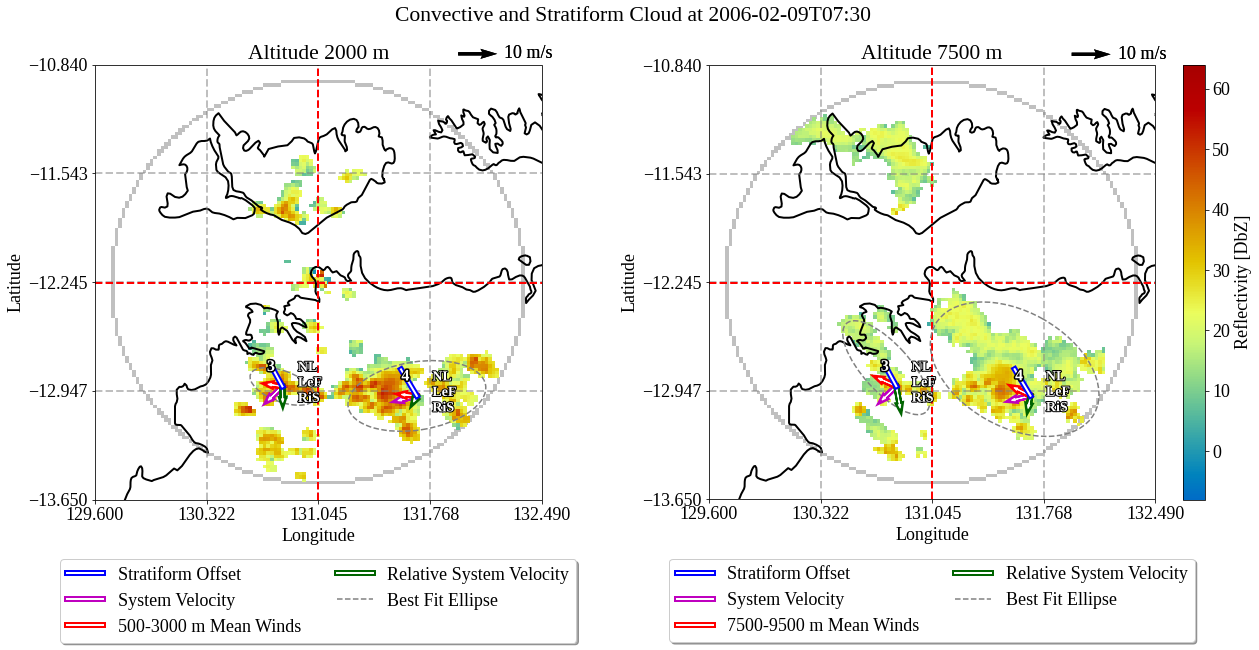

In [10]:
filename = filenames[45]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False, 'winds_fn': filename, 
    'crosshair': True, 'fontsize': 18, 'colorbar_flag': True,
    'leg_loc': 2, 'system_winds': ['shift', 'ambient_mean', 'relative']}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=2000)
plt.savefig(
    fig_dir + '/horizontal_cs_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')
plt.show()
plt.close('all')

In [132]:
np.arccos(1)

0.0

In [185]:
tracks_obj.params['EXCL_THRESH']['SMALL_AREA'] = 500

In [27]:
filename=filenames[80]
grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'
uid_ind = '4'

params = {
    'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filename,
    'direction': 'perpendicular', 'crosshair': True, 
    'save_dir': fig_dir, 'line_average': True, 'streamplot': False, 
    'relative_winds': True, 'data_fn': None, 
    'load_line_coords_winds': True, 'fontsize': 14}

tint.visualisation.figures.vertical_cross_section(
    tracks_obj, grid, params=params)

Transformed data not found. Calculating.
Interpolating onto line coordinates.
Adding reflectivity.
Adding stratiform offset.


In [6]:
dates = np.arange(
    np.datetime64('2006-02-09 07:00'), 
    np.datetime64('2006-02-09 07:30'),
    np.timedelta64(10, 'm'))

filenames, start_time, end_time = cf.CPOL_files_from_datetime_list(
    dates, base_dir=base_dir)

Gathering files.


In [223]:
params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False, 
    'cell_ind': 10, 'winds': False, 'winds_fn': filenames, 
    'crosshair': True, 'save_dir': fig_dir, 'alt': 3000, 
    'colorbar_flag': True, 'leg_loc': 1, 'fontsize': 18}

grids = (
    pyart.io.read_grid(fn, include_fields = ['reflectivity'])
    for fn in filenames)

tint.visualisation.animate.animate(
    tracks_obj, grids, params, fig_type='two_level', 
    start_datetime=np.datetime64('2006-02-09 07:00'), 
    end_datetime=np.datetime64('2006-02-09 07:30'))

IndexError: index 0 is out of bounds for axis 0 with size 0

> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/visualisation/animate.py(40)check_times()
     38     grid_time = grid_time.astype('datetime64[m]')
     39     if grid_time > date_times[0]:
---> 40         ind = np.argwhere(date_times == grid_time)[0, 0]
     41         if not ind:
     42             print('Object occurs before grids provided. Aborting')

ipdb> q


Generating frame 2006-02-09T05:10:00.000000000


KeyError: 'orientation_alt'

> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pandas/core/indexes/base.py(3363)get_loc()
   3361                 return self._engine.get_loc(casted_key)
   3362             except KeyError as err:
-> 3363                 raise KeyError(key) from err
   3364 
   3365         if is_scalar(key) and isna(key) and not self.hasnans:

ipdb> q


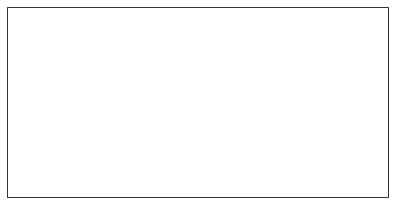

In [10]:
for uid_ind in np.arange(2).astype(str):
    fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures'

    params = {
        'uid_ind': uid_ind, 'line_coords': True, 'center_cell': False, 
        'cell_ind': 7, 'winds': True, 'winds_fn': filenames, 
        'direction': 'perpendicular', 'crosshair': True, 'save_dir': fig_dir,
        'line_average': True, 'streamplot': True, 'relative_winds': True,
        'data_fn': 'angles', 'load_line_coords_winds': False, 
        'save_ds': True}

    grids = (
        pyart.io.read_grid(fn, include_fields = ['reflectivity'])
        for fn in filenames)

    tint.visualisation.animate.animate(tracks_obj, grids, params)